# Summary of Notebook #
1. Got daily data on Ark returns, Ark current holdings, and historical returns of Ark current holdings. Also got daily macro asset returns and equity indices data.
2. Analyzed Ark's returns profile. 
3. Analyzed Ark's exposure to broad US equity indices. Focused particularly on when Ark underperforms. 
4. Analyzed Ark's macro exposures on static and rolling basis. 
5. Used PCA to explain the returns on the individual assets in Ark's current holdings.
6. Analyzed macro exposures of the current holdings. 

# Main Takeaways #
1. Ark has high beta > 1 on US equities, performing like a levered version of the S&P/Nasdaq (they don't actually use leverage). 
2. Ark performs particularly poorly during major drawdowns in US equities. We can hedge this with options and optimize strike/maturity based on which types of drawdowns hurt Ark the most. 
3. In addition to US equities, Ark has statistically significant regression betas to US treasuries and commodities. 
4. Through PCA, we see that Ark's current holdings are particularly exposed to the health care sector, which we could hedge with a health care sector ETF.
5. We can dynamically assess the risk factors of Ark's holdings over time through rolling PCA/regression.

# Next Steps #
1. Calibration SPY options hedging strategy.
2. Determine other macro hedges: rates, commodities, healthcare.

---------------------------------------------------------------------------------------------------------------------------------------------------------

# Import and Clean Data #

In [85]:
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.simplefilter("ignore")
from scipy import stats
from sklearn.decomposition import PCA


### Load ARKK Holdings Data as of 2025-05-16 ###
This tells us Ark's current holdings, including the dollar weight in the portfolio on each name.

In [86]:
holdings = pd.read_csv('./data/holdings.csv').dropna()
holdings['weight (%)'] = holdings ['weight (%)'].str.rstrip('%').astype(float) / 100
holdings = holdings.rename(columns={'weight (%)': 'weight'})
holdings

,date,fund,company,ticker,cusip,shares,market value ($),weight
0,05/14/2025,ARKK,TESLA INC,TSLA,88160R101,"2,236,468","$747,136,864.76",0.1256
1,05/14/2025,ARKK,COINBASE GLOBAL INC -CLASS A,COIN,19260Q107,"2,055,170","$527,973,173.00",0.0887
2,05/14/2025,ARKK,ROKU INC,ROKU,77543R102,"6,287,334","$448,915,647.60",0.0755
3,05/14/2025,ARKK,ROBLOX CORP -CLASS A,RBLX,771049103,"5,729,978","$441,322,905.56",0.0742
4,05/14/2025,ARKK,TEMPUS AI INC,TEM,88023B103,"5,283,141","$364,061,246.31",0.0612
5,05/14/2025,ARKK,PALANTIR TECHNOLOGIES INC-A,PLTR,69608A108,"2,672,586","$342,358,266.60",0.0575
6,05/14/2025,ARKK,ROBINHOOD MARKETS INC - A,HOOD,770700102,"4,870,036","$304,718,152.52",0.0512
7,05/14/2025,ARKK,SHOPIFY INC - CLASS A,SHOP,82509L107,"2,729,354","$293,896,838.72",0.0494
8,05/14/2025,ARKK,CRISPR THERAPEUTICS AG,CRSP,H17182108,"6,940,182","$258,313,574.04",0.0434
9,05/14/2025,ARKK,ARCHER AVIATION INC-A,ACHR,03945R102,"16,105,839","$179,741,163.24",0.0302


### Load Ark Returns Series ###
We get the prices on Ark over time from yahoo finance. We use close prices and convert to a returns series.

In [87]:
arkData = yf.download("ARKK", start="2014-10-31", end="2024-12-31")['Close', 'ARKK']
arkRets = arkData.pct_change().dropna()
arkRets.name = 'Ark'
arkRets.to_csv('./data/ark.csv')


[*********************100%***********************]  1 of 1 completed


### Load Price Series for all Current Ark Holdings ###
We collect historical price series data for the returns on each of Ark's current assets. Note that the NaN values are because the asset wasn't public yet.

In [88]:
tickers = holdings['ticker'].tolist()
tickerPrices = yf.download(tickers, start="2014-10-31")["Close"]
tickerRets = tickerPrices.pct_change().drop(columns = ['DKNG UW']).dropna(how='all', axis=0)
tickerRets

[*********************100%***********************]  35 of 35 completed

1 Failed download:
['DKNG UW']: YFTzMissingError('possibly delisted; no timezone found')


Ticker,ACHR,AMD,AMZN,BEAM,CERS,COIN,CRSP,DE,GH,GTLB,...,SHOP,SOFI,TEM,TER,TSLA,TTD,TWST,TXG,VCYT,XYZ
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-03,NaN,0.025000,0.000851,NaN,0.000000,NaN,NaN,-0.006313,NaN,NaN,...,NaN,NaN,NaN,0.004891,0.003682,NaN,NaN,NaN,-0.007435,NaN
2014-11-04,NaN,-0.013937,-0.009519,NaN,-0.016827,NaN,NaN,-0.005294,NaN,NaN,...,NaN,NaN,NaN,-0.001623,-0.015087,NaN,NaN,NaN,0.046192,NaN
2014-11-05,NaN,-0.010601,-0.020772,NaN,-0.041565,NaN,NaN,0.004967,NaN,NaN,...,NaN,NaN,NaN,0.034670,-0.033315,NaN,NaN,NaN,-0.017900,NaN
2014-11-06,NaN,-0.014286,0.000405,NaN,0.015306,NaN,NaN,0.032953,NaN,NaN,...,NaN,NaN,NaN,0.010471,0.044378,NaN,NaN,NaN,-0.018226,NaN
2014-11-07,NaN,0.007246,0.010855,NaN,0.007538,NaN,NaN,0.010140,NaN,NaN,...,NaN,NaN,NaN,-0.013471,-0.004229,NaN,NaN,NaN,-0.043317,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-14,0.060932,0.046772,-0.005299,-0.044875,-0.045801,0.025341,-0.043525,-0.002146,-0.015474,0.001312,...,0.035011,-0.018195,-0.059933,-0.007421,0.040740,0.012798,-0.085785,-0.054922,-0.027977,0.005673
2025-05-15,0.029561,-0.023191,-0.024162,0.000580,0.032000,-0.072017,0.019944,0.037829,-0.006385,-0.030320,...,-0.011126,-0.032787,-0.033652,-0.015189,-0.013978,-0.020723,0.019648,0.008772,0.000000,-0.025470
2025-05-16,0.091058,0.018958,0.002047,0.037101,0.031008,0.090083,0.067750,0.029362,0.005190,-0.006176,...,0.004900,0.025792,0.046166,-0.003133,0.020886,-0.015355,0.027575,0.020652,0.024921,0.011402


### Construct Historical Returns Series for Ark's Current Portfolio  ###
First, we create a dataframe of asset weights over time. We can't just use the constant weights from today because many of the assets in today's Ark holdings only became public after Ark's inception. To deal with this, we renormalize portfolio weights at each time by adding weight to the existing assets such that the sum of asset weights at any time is 1. Thus we have a series of portfolio weights that approximates Ark's current portfolio.

In [89]:
weights_dict = {}
for t, w in zip(holdings['ticker'], holdings['weight']):
    if t == 'DKNG UW':
        continue
    else:
        weights_dict[t] = w

weights_df = pd.DataFrame([weights_dict] * len(tickerRets), index=tickerRets.index)
weights_df = weights_df.mask(tickerRets.isna(), 0)
weights_df = weights_df.div(weights_df.sum(axis=1), axis=0).dropna(how='all', axis=0)
weights_df.to_csv("data/weights.csv")
weights_df

,TSLA,COIN,ROKU,RBLX,TEM,PLTR,HOOD,SHOP,CRSP,ACHR,...,NTLA,ILMN,DE,IRDM,VCYT,NVDA,GH,PACB,CERS,SOFI
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-03,0.479389,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.040840,0.038931,0.038550,0.037023,0.032824,0.000000,0.017176,0.009542,0.000000
2014-11-04,0.479389,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.040840,0.038931,0.038550,0.037023,0.032824,0.000000,0.017176,0.009542,0.000000
2014-11-05,0.479389,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.040840,0.038931,0.038550,0.037023,0.032824,0.000000,0.017176,0.009542,0.000000
2014-11-06,0.479389,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.040840,0.038931,0.038550,0.037023,0.032824,0.000000,0.017176,0.009542,0.000000
2014-11-07,0.479389,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.040840,0.038931,0.038550,0.037023,0.032824,0.000000,0.017176,0.009542,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-14,0.128268,0.090584,0.077104,0.075776,0.0625,0.058721,0.052288,0.050449,0.044322,0.030842,...,0.012561,0.010927,0.010417,0.010315,0.009906,0.008783,0.005719,0.004596,0.002553,0.000306
2025-05-15,0.128268,0.090584,0.077104,0.075776,0.0625,0.058721,0.052288,0.050449,0.044322,0.030842,...,0.012561,0.010927,0.010417,0.010315,0.009906,0.008783,0.005719,0.004596,0.002553,0.000306
2025-05-16,0.128268,0.090584,0.077104,0.075776,0.0625,0.058721,0.052288,0.050449,0.044322,0.030842,...,0.012561,0.010927,0.010417,0.010315,0.009906,0.008783,0.005719,0.004596,0.002553,0.000306


Now we have both the weights series and returns series by asset. To get the portfolio returns series, we just take the inner product weights * returns at each time. From now on we will refer to the synthetic portfolio defined by the weights series as "Synthetic Ark." The returns on synthetic Ark approximate the historical returns of a hypothetical portfolio consisting of Ark's current holdings.



In [90]:
syntheticArk = (weights_df * tickerRets).sum(axis=1)

### Load Macro Assets Data ###

Getting daily series, and only the US-relevant macro assets.

In [91]:
tickers = ['SPY', 'GD=F', 'HYG', 'GOLD', 'EURUSD=X', 'JPY=X']

start_date = '2014-10-31'
end_date = '2025-05-16'

dfs_full = {}

for ticker in tickers: 
    prices = yf.Ticker(ticker).history(start=start_date, end=end_date, auto_adjust=True)['Close']
    rets = prices.pct_change()
    dfs_full[ticker] = pd.DataFrame(index = rets.index, data ={'Return': rets}).dropna()


tsy_series = pdr.FredReader('DGS10', start = start_date, end = end_date).read()/100
D, C = 8,80
delta_y = tsy_series.diff()
tsy_price_ret = -D * delta_y + 0.5 * C * delta_y ** 2
tsy_carry_ret = tsy_series/252
tsy_ret = (tsy_carry_ret + tsy_price_ret).dropna()

dfs_full['TSY']=pd.DataFrame(index = tsy_series.index, data ={'Return':  tsy_ret['DGS10']})

for ticker in dfs_full:
    dfs_full[ticker].index = dfs_full[ticker].index.tz_localize(None)

 

In [92]:
macroRets = pd.DataFrame()
for t in dfs_full:
    macroRets[t] = dfs_full[t]['Return']


AssetNamesMap = { 'GD=F':'Commodities', 'HYG':'US HY', 
                 'EURUSD=X':'EURUSD', 'TSY':'US GOVT', 'JPY=X':'USDJPY'}

macroRets = macroRets.rename(columns=AssetNamesMap).dropna()


### Get US Equity Benchmarks Data ###
Based on prior knowledge, Ark may load more on NASDAQ than on SPY.

In [93]:
QQQ = yf.download("QQQ", start="2014-10-31", end="2024-12-31")['Close', 'QQQ']
SPY = yf.download("SPY", start="2014-10-31", end="2024-12-31")['Close', 'SPY']

QQQRets = QQQ.pct_change().dropna()
QQQRets.name = 'QQQ'
SPYRets = SPY.pct_change().dropna()
SPYRets.name = 'SPY'

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Ark Univariate Returns Profile #
Here we'll look at at the univariate returns profiles of three assets/indices: Ark, SPY, and QQQ.  

#### Cumulative Returns Plots: ####

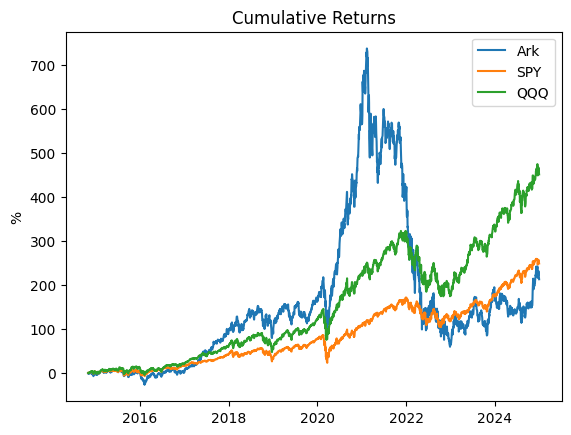

In [94]:
for retSeries in [arkRets, SPYRets, QQQRets]:
    cumRets = ((1 + retSeries).cumprod() - 1) * 100
    plt.plot(cumRets, label=retSeries.name)

plt.legend()
plt.ylabel('%')
plt.title('Cumulative Returns');

Cumulative returns for SPY and Ark have been similar, but Ark had a massive run post-COVID and then a huge drawdown. Ark thus has had much higher vol than SPY. 

Return Profile Summary Statistics:

In [95]:
def SummarizeReturns(returns: pd.Series, risk_free_rate: float = 0.0, confidence: float = 0.05, periods_per_year: int = 252) -> pd.Series:
    """
    Summarizes a series of daily returns with annualized performance metrics.

    Parameters:
        returns (pd.Series): Daily return series (arithmetic)
        risk_free_rate (float): Daily risk-free rate (default 0.0)
        confidence (float): For Value at Risk (VaR), default is 5%
        periods_per_year (int): Number of trading periods per year (default 252 for daily)

    Returns:
        pd.Series: Annualized summary statistics
    """

    mean_daily = returns.mean()
    std_daily = returns.std()

    mean_annual = mean_daily * periods_per_year
    std_annual = std_daily * np.sqrt(periods_per_year)

    sharpe = (mean_annual - risk_free_rate * periods_per_year) / std_annual if std_annual > 0 else np.nan

    downside_std_daily = returns[returns < 0].std()
    downside_std_annual = downside_std_daily * np.sqrt(periods_per_year)
    sortino = (mean_annual - risk_free_rate * periods_per_year) / downside_std_annual if downside_std_annual > 0 else np.nan

    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdowns = (cumulative - running_max) / running_max
    max_drawdown = drawdowns.min()

    var = returns.quantile(confidence)

    return pd.Series({
        "Annualized Mean": mean_annual,
        "Annualized Std Dev": std_annual,
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Max Drawdown": max_drawdown,
        f"{int(confidence*100)}% Daily VaR": var
    })


In [96]:
retsSummary = pd.DataFrame({'Ark': SummarizeReturns(arkRets).values,  'SPY': SummarizeReturns(SPYRets), 'QQQ': SummarizeReturns(QQQRets)}, index = SummarizeReturns(arkRets).index)
retsSummary

,Ark,SPY,QQQ
Annualized Mean,0.183690,0.138728,0.192012
Annualized Std Dev,0.376702,0.175371,0.216972
Sharpe Ratio,0.487626,0.791058,0.884961
Sortino Ratio,0.674961,0.957072,1.124563
Max Drawdown,-0.809141,-0.337173,-0.351187
5% Daily VaR,-0.038262,-0.016681,-0.022286


Noting the massive max drawdown numbers, we think that the results using arithmetic returns significantly overstate performance on a compounded basis. Here are the same numbers but using geometric mean returns instead of arithmetic mean returns:

In [97]:
def GeomSummary(returns: pd.Series, risk_free_rate: float = 0.0, confidence: float = 0.05, periods_per_year: int = 252) -> pd.Series:
    """
    Summary of return metrics using geometric mean in ratio calculations.
    
    Parameters:
        returns: pd.Series of daily arithmetic returns
        risk_free_rate: daily risk-free rate (default 0)
        confidence: for Value at Risk (VaR), default is 5%
        periods_per_year: default 252 (daily returns)

    Returns:
        pd.Series with summary stats
    """
    # Geometric mean return (annualized)
    gross_return = (1 + returns).prod()
    years = len(returns) / periods_per_year
    geom_mean_annual = gross_return**(1 / years) - 1

    # Std dev (based on arithmetic mean)
    std_annual = returns.std() * np.sqrt(periods_per_year)

    # Downside std dev
    downside_std = returns[returns < 0].std()
    downside_std_annual = downside_std * np.sqrt(periods_per_year)

    # Ratios using geometric mean
    sharpe = (geom_mean_annual - risk_free_rate * periods_per_year) / std_annual if std_annual > 0 else np.nan
    sortino = (geom_mean_annual - risk_free_rate * periods_per_year) / downside_std_annual if downside_std_annual > 0 else np.nan

    # Max drawdown
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdowns = (cumulative - running_max) / running_max
    max_drawdown = drawdowns.min()

    # Daily VaR
    var = returns.quantile(confidence)

    return pd.Series({
        "Geometric Mean Return (Annualized)": geom_mean_annual,
        "Annualized Std Dev": std_annual,
        "Sharpe Ratio (Geo)": sharpe,
        "Sortino Ratio (Geo)": sortino,
        "Max Drawdown": max_drawdown,
        f"{int(confidence*100)}% Daily VaR": var
    })


In [98]:
geomSummary = pd.DataFrame({'Ark': GeomSummary(arkRets).values, 'SPY': GeomSummary(SPYRets), 'QQQ': GeomSummary(QQQRets)}, index = GeomSummary(arkRets).index)
geomSummary

,Ark,SPY,QQQ
Geometric Mean Return (Annualized),0.119153,0.131177,0.183342
Annualized Std Dev,0.376702,0.175371,0.216972
Sharpe Ratio (Geo),0.316307,0.747996,0.845005
Sortino Ratio (Geo),0.437825,0.904972,1.073789
Max Drawdown,-0.809141,-0.337173,-0.351187
5% Daily VaR,-0.038262,-0.016681,-0.022286


# Ark's Factor Exposures #

### US Equity Index Exposures ###

First let's run univariate regressions of Ark returns on US equity index returns.

In [99]:
def GetRegSummary(dependent: pd.Series, independent: pd.Series) -> pd.Series:
    """
    Regresses `dependent` on `independent` and returns alpha, beta, R², and p-value.

    Parameters:
        dependent (pd.Series): Y-variable (e.g., asset or portfolio returns)
        independent (pd.Series): X-variable (e.g., benchmark returns)

    Returns:
        pd.Series: Alpha, Beta, R², and p-value for Beta
    """

    
    # Align and clean
    df = pd.concat(objs=[dependent, independent], axis=1).dropna()
    y = df.iloc[:, 0]
    X = sm.add_constant(df.iloc[:, 1])

    # Fit model
    model = sm.OLS(y, X).fit()

    #Get IR
    preds = model.predict(X) 
    activeRets = y - preds + model.params['const']
    IR = np.mean(activeRets) / np.std(activeRets)

    regSummary = pd.Series({
        'Alpha': model.params['const'],
        'Beta': model.params[X.columns[1]],
        'R_squared': model.rsquared,
        'P_value (Alpha)': model.pvalues[X.columns[0]], 
        'P_value (Beta)': model.pvalues[X.columns[1]],
        'Info. Ratio': IR
    })

    return regSummary
    


In [100]:
regSummary = pd.DataFrame({'SPY': GetRegSummary(arkRets, SPYRets), 'QQQ':GetRegSummary(arkRets, QQQRets)})
round(regSummary,3)

,SPY,QQQ
Alpha,-0.000,-0.000
Beta,1.508,1.341
R_squared,0.493,0.597
P_value (Alpha),0.763,0.327
P_value (Beta),0.000,0.000
Info. Ratio,-0.006,-0.019


### Hypothesis ###
Ark seems to perform best relative to SP500 during sustained bull markets, and worst during sustained bear markets. This suggests we should hedge longer term market downturns, rather than shorter term market downturns. We can test this by creating market upswing/downswing dummy variables and then performing a two sample t-test for difference in means. We can optimize our hedge by selecting instruments to hedge the particular scenarios in which Ark performs worst.

In [101]:
def label_market_swings(df: pd.DataFrame, spy_col: str = 'SPY', window: int = 100, threshold: float = 0.1) -> pd.DataFrame:
    """
    Labels each 100-day partition with 'upswing' and 'downswing' flags based on SPY cumulative returns.

    Parameters:
        df (pd.DataFrame): DataFrame containing return columns
        spy_col (str): Name of SPY return column
        window (int): Partition size
        threshold (float): +/- cumulative return threshold for swing classification

    Returns:
        pd.DataFrame: Original dataframe with 'upswing' and 'downswing' columns
    """
    df = df.copy()
    n = len(df)

    upswing = pd.Series(index=df.index, dtype=int)
    downswing = pd.Series(index=df.index, dtype=int)

    for i in range(0, n, window):
        segment = df.iloc[i:i+window]
        cum_return = (1 + segment[spy_col]).prod() - 1

        upswing_flag = int(cum_return > threshold)
        downswing_flag = int(cum_return < -threshold)

        upswing.iloc[i:i+window] = upswing_flag
        downswing.iloc[i:i+window] = downswing_flag

    df['upswing'] = upswing
    df['downswing'] = downswing

    return df



In [102]:
def difference_in_means_test(df: pd.DataFrame, return_col: str = 'excess') -> dict:
    """
    Performs a one-sided t-test comparing mean excess return during upswings vs. downswings.

    Parameters:
        df (pd.DataFrame): DataFrame with 'upswing', 'downswing', and return columns
        return_col (str): Name of the column with excess returns

    Returns:
        dict: Test statistic and p-value for the one-sided t-test (upswing > downswing)
    """
    up_returns = df.loc[df['upswing'] == 1, return_col].dropna()
    down_returns = df.loc[df['downswing'] == 1, return_col].dropna()

    # Perform one-sided Welch’s t-test: H0: mean_up <= mean_down vs H1: mean_up > mean_down
    t_stat, p_value_two_sided = stats.ttest_ind(up_returns, down_returns, equal_var=False)

    # Convert to one-sided p-value for H1: mean_up > mean_down
    if t_stat > 0:
        p_value_one_sided = p_value_two_sided / 2
    else:
        p_value_one_sided = 1 - (p_value_two_sided / 2)

    return {
        "t_statistic": t_stat,
        "p_value (one-sided)": p_value_one_sided,
        "mean_upswing": up_returns.mean(),
        "mean_downswing": down_returns.mean(),
        "difference": up_returns.mean() - down_returns.mean()
    }

In [103]:
def grid_test_p_values(df: pd.DataFrame, spy_col: str, return_col: str,
                       window_values: list, threshold_values: list) -> pd.DataFrame:
    """
    Performs a grid search over window and threshold values for market swing labeling,
    and computes the p-value of the difference in means test at each combination.

    Parameters:
        df (pd.DataFrame): Input DataFrame with SPY and excess return columns
        spy_col (str): Name of the SPY returns column
        return_col (str): Name of the excess return column
        window_values (list): List of window sizes to test
        threshold_values (list): List of return thresholds to test

    Returns:
        pd.DataFrame: DataFrame of p-values with thresholds as rows and windows as columns
    """
    pval_matrix = pd.DataFrame(index=threshold_values, columns=window_values, dtype=float)

    for threshold in threshold_values:
        for window in window_values:
            # Label swings
            labeled = label_market_swings(df, spy_col=spy_col, window=window, threshold=threshold)

            # Compute t-test and store p-value
            result = difference_in_means_test(labeled, return_col=return_col)
            pval_matrix.at[threshold, window] = result["p_value (one-sided)"]
    
    pval_matrix.index.name = '% Swing'
    pval_matrix.columns.name = 'Days'

    return round(pval_matrix, 4)


In [104]:
equityRets = pd.DataFrame({'SPY': SPYRets, 'Ark': arkRets})
equityRets['excess'] = arkRets - SPYRets

In [105]:
windows = [50, 100, 150, 200, 250, 300]
thresholds = [0.05, 0.1, 0.15, 0.2]

Text(0.5, 1.0, 'P Values for Difference in Mean Excess Returns')

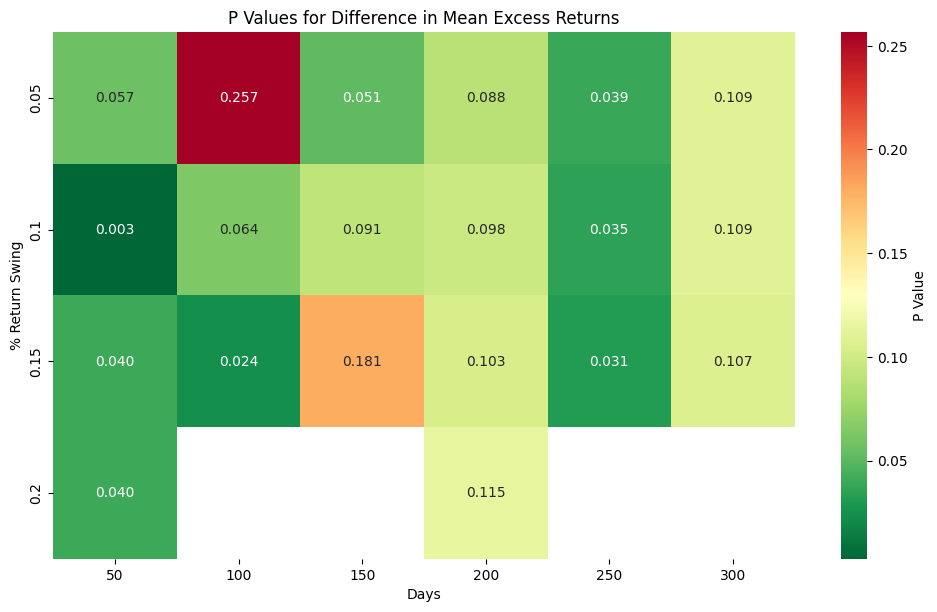

In [106]:
pvals = grid_test_p_values(equityRets, 'SPY', 'excess', windows, thresholds)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(pvals, annot=pvals,fmt=".3f", cmap="RdYlGn_r", cbar_kws={"label": "P Value"})
plt.xlabel("Days")
plt.ylabel("% Return Swing")
plt.tight_layout()
plt.title('P Values for Difference in Mean Excess Returns')



Each entry in the heatmap above says "if the cumulative return of SPY was above/below  [0.05, 0.1, 0.15, 0.2] in the last [50, 100, 150, 200, 250, 300] then p-value is difference in mean returns of ARK during periods of up/down swings. 

Basically, the [0.05, 50] takes all the mean returns of ARK during periods where the S&P experinced a downswing of more that 0.05 over 50 days, and takes the mean return of ARK during periods where the S&P experienced an upswing of more that 0.05 over 50 days and the p-value is the statistical measure of if the mean of those returns differed. The p-value = 0.003 for [0.1, 50] tells us that the most variability in ARK's performance happens in periods where the S&P has a cumulative return of 0.1 in the last 50 days. 

Note that this could guide a SPY put option buying strategy: it tells us over what time horizons and what percentage moves in SPY that we see the most statistically significant difference between upswing performance and downswing performance. For example, we might want to buy SPY puts at 10% out of the money for K = 50 (trading days), while selling calls at 10% in the money for K=50 (because that's the most statistically significant).

### Macro Exposures ###

Regress Ark returns against macro factors:

In [107]:
merged = pd.merge(macroRets, arkRets, how='inner', left_on=macroRets.index, right_on = arkRets.index)
y = merged['Ark']
X = merged[macroRets.columns]

In [108]:
model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    Ark   R-squared (uncentered):                   0.515
Model:                            OLS   Adj. R-squared (uncentered):              0.513
Method:                 Least Squares   F-statistic:                              365.9
Date:                Tue, 20 May 2025   Prob (F-statistic):                        0.00
Time:                        19:17:45   Log-Likelihood:                          6496.9
No. Observations:                2422   AIC:                                 -1.298e+04
Df Residuals:                    2415   BIC:                                 -1.294e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

On a rolling basis, using only the statistically significant macro factors and combining HY and SPY to prevent multicollinearity:

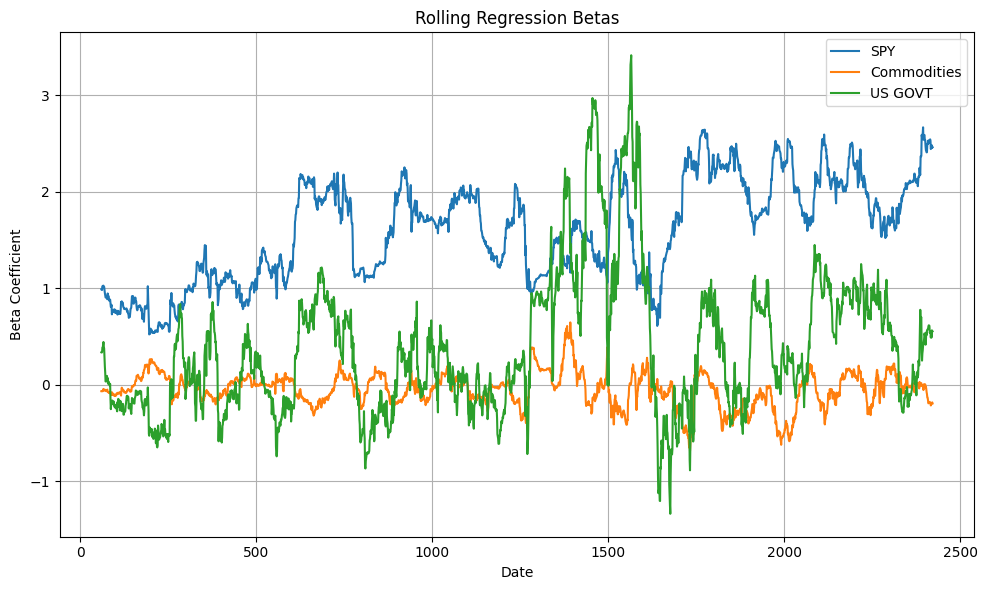

In [109]:
y = merged['Ark']
X = merged[macroRets.columns][['SPY', 'Commodities', 'US GOVT']]

window_size = 60  # adjust as needed


# Store rolling betas
betas = []

# Rolling regression
for i in range(window_size, len(merged)):
    y_window = y.iloc[i - window_size:i]
    X_window = X.iloc[i - window_size:i]
    
    model = sm.OLS(y_window, X_window).fit()
    betas.append(model.params)

# Create DataFrame of betas
betas_df = pd.DataFrame(betas, index=merged.index[window_size:])

# Plot
betas_df.plot(figsize=(10, 6), title='Rolling Regression Betas')
plt.xlabel('Date')
plt.ylabel('Beta Coefficient')
plt.grid(True)
plt.tight_layout()
plt.show()

In addition to hedging SPY downturns as discussed in the previous section, we should also consider hedging commodities, US high yield, and US treasuries, all of which have statistically significant betas.

### Principal Component Analysis on Ark Holdings ###

If we now consider the portfolio given by Ark's current holdings, can we find the principal components for this portfolio and then assess the principal components' macro exposures?

Text(0, 0.5, 'Count')

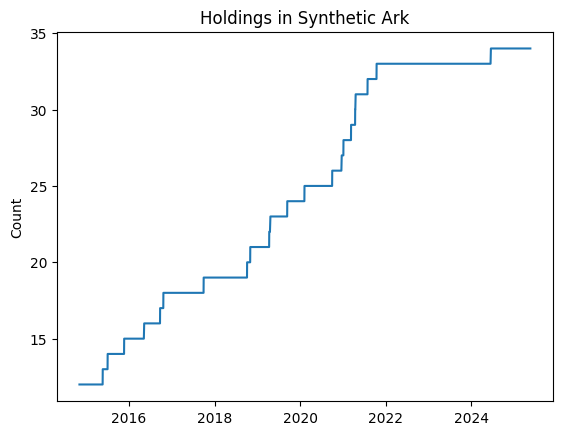

In [110]:
tickerRets['ticker count'] = tickerRets.notna().sum(axis=1)
plt.plot(tickerRets['ticker count'])
plt.title('Holdings in Synthetic Ark')
plt.ylabel('Count')

Based on the chart above, let's look at the data since 2022. 

In [111]:
from sklearn.preprocessing import StandardScaler
tickerRetsRecent = tickerRets.loc['2022':].dropna(how='any', axis=1)
X = (tickerRetsRecent - tickerRetsRecent.mean())
X.drop(columns='ticker count', inplace=True)
X_names = X.copy()
scaler = StandardScaler()
X = scaler.fit_transform(X)
pca = PCA(n_components=3)
pca.fit(X)


loadings = pd.DataFrame(
    pca.components_.T,
    index=X_names
.columns,
    columns=['PC1', 'PC2', 'PC3']
)


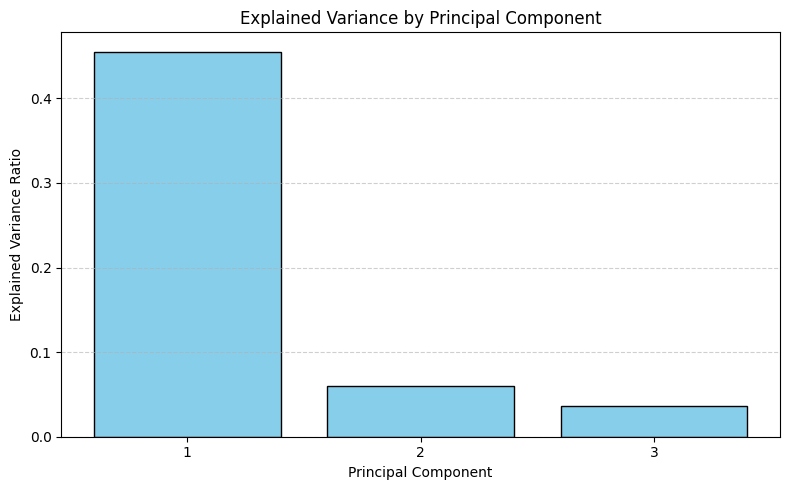

In [112]:
explained_var = pca.explained_variance_ratio_

# Plot the explained variance
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_var) + 1), explained_var, color='skyblue', edgecolor='black')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Component')
plt.xticks(range(1, len(explained_var) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

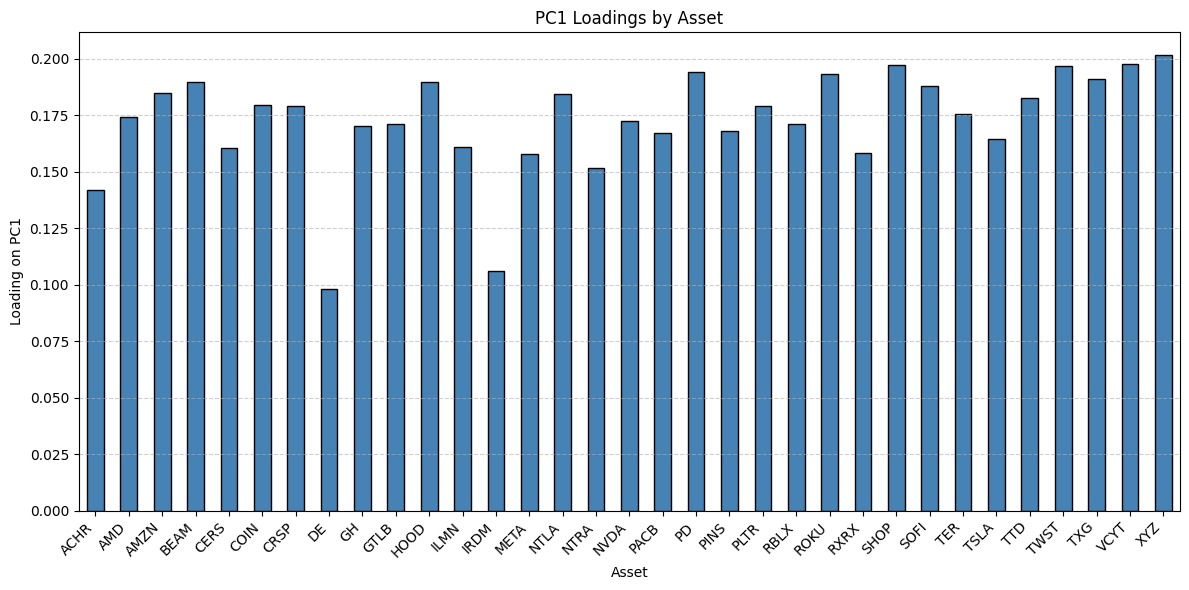

In [113]:
plt.figure(figsize=(12, 6))
loadings['PC1'].plot(kind='bar', color='steelblue', edgecolor='black')

plt.title('PC1 Loadings by Asset')
plt.xlabel('Asset')
plt.ylabel('Loading on PC1')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


By far the most variance is explained by PC1. Unsurprisingly, PC1 loadings all have the same sign. This is basically an overall equity market factor. 

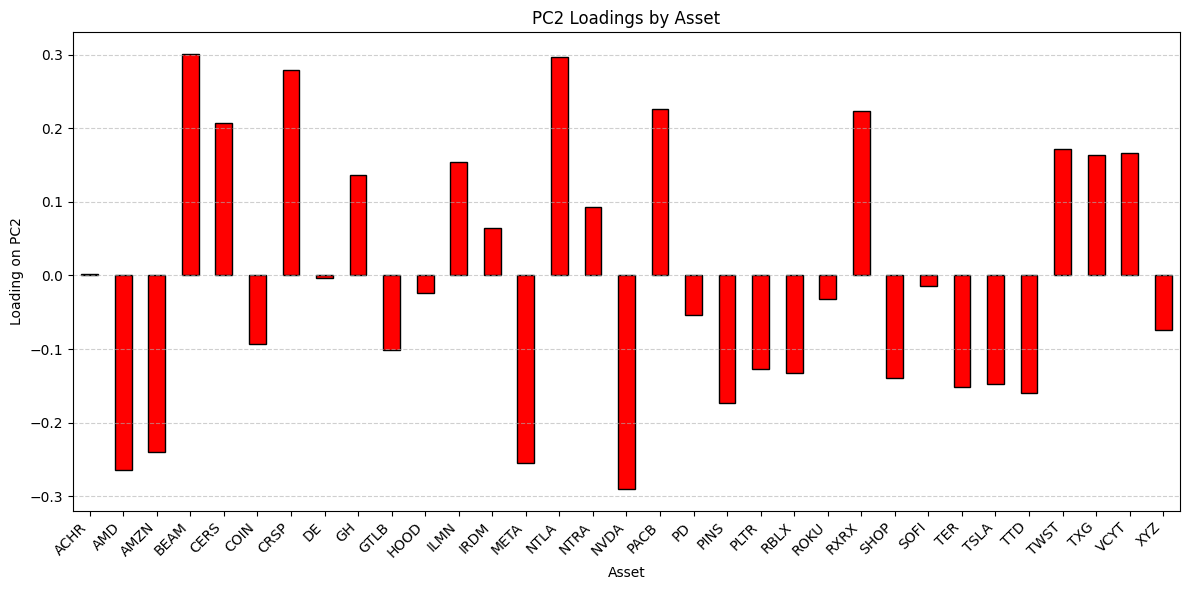

In [114]:
plt.figure(figsize=(12, 6))
loadings['PC2'].plot(kind='bar', color='red', edgecolor='black')

plt.title('PC2 Loadings by Asset')
plt.xlabel('Asset')
plt.ylabel('Loading on PC2')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The second PC is the health care sector. All of the assets with positive PC2 loadings are in the healthcare sector, eg. Crispr Therapeutics. Based on this, we may want to consider a healthcare sector hedge to prevent macro sector exposure.

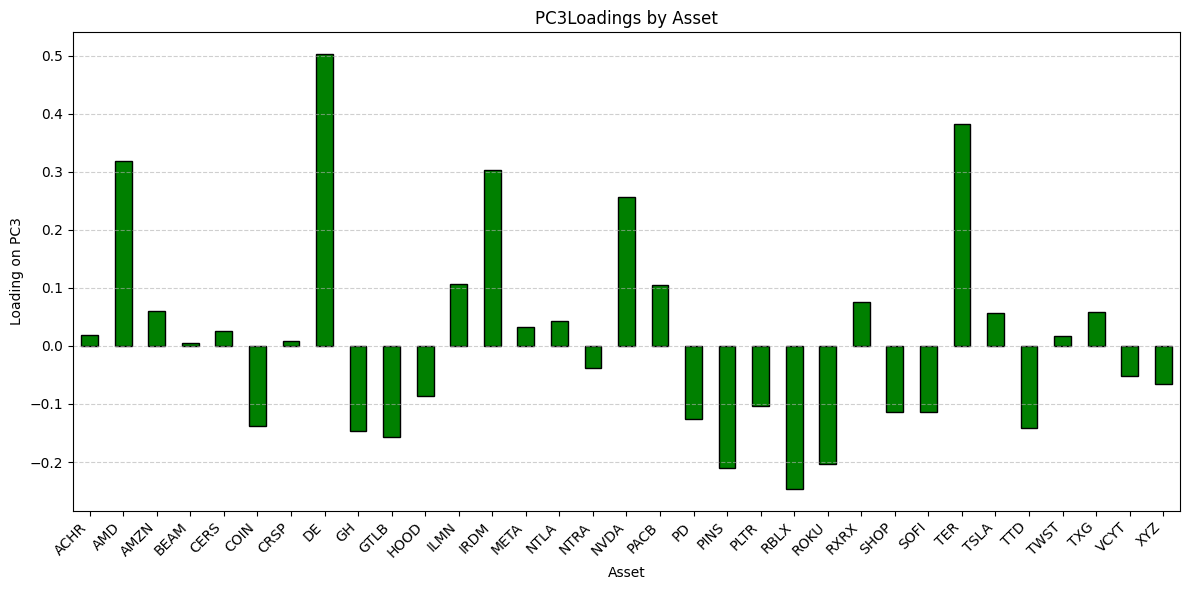

In [115]:
plt.figure(figsize=(12, 6))
loadings['PC3'].plot(kind='bar', color='green', edgecolor='black')

plt.title('PC3Loadings by Asset')
plt.xlabel('Asset')
plt.ylabel('Loading on PC3')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

It is unclear what PC3 represents and it is likely statistical noise. 

### Macro Hedging with Ark Holdings ###

We have already calculated the returns on Synthetic Ark. Given that Synthetic Ark is composed of the current Ark holdings, one could argue that it's more important to hedge Synthetic Ark's returns than Ark's historical returns. Therefore we will regress Synthetic Ark's returns on the important macro assets below.

In [116]:
syntheticRetsRecent = syntheticRets.loc['2022':]
macroRetsRecent = macroRets[macroRets.index.isin(syntheticRetsRecent.index)][['SPY', 'Commodities', 'US GOVT']]
syntheticRetsRecent = syntheticRetsRecent[syntheticRetsRecent.index.isin(macroRetsRecent.index)]

NameError: name 'syntheticRets' is not defined

In [ ]:
model = sm.OLS(syntheticRetsRecent, macroRetsRecent).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.627
Model:                            OLS   Adj. R-squared (uncentered):              0.625
Method:                 Least Squares   F-statistic:                              448.0
Date:                Sat, 17 May 2025   Prob (F-statistic):                   1.01e-170
Time:                        00:58:59   Log-Likelihood:                          2041.9
No. Observations:                 803   AIC:                                     -4078.
Df Residuals:                     800   BIC:                                     -4064.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

To make this a dynamic tool that can be used to assess Ark's macro exposures on an ongoing basis, we can run rolling regressions:

In [ ]:
allRets = pd.concat([syntheticRets, macroRets[['SPY', 'Commodities', 'US GOVT']]], axis=1).dropna()
allRets.rename(columns={0:'syntheticArk'}, inplace=True)

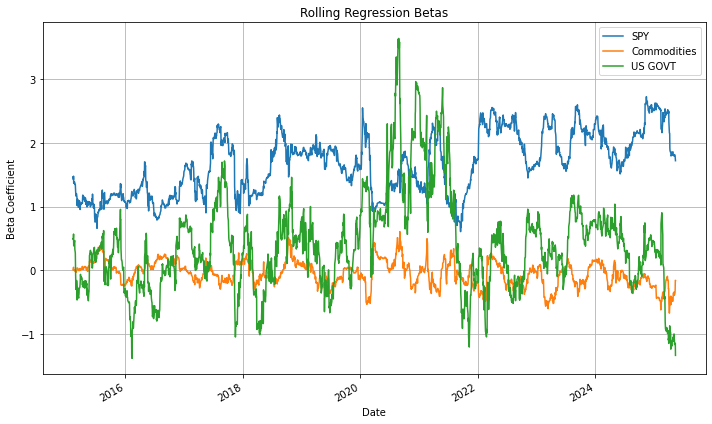

In [ ]:
window_size = 60  # adjust as needed

# Prepare Data
y = allRets['syntheticArk']
X = allRets.drop(columns=['syntheticArk'])

# Store rolling betas
betas = []

# Rolling regression
for i in range(window_size, len(allRets)):
    y_window = y.iloc[i - window_size:i]
    X_window = X.iloc[i - window_size:i]
    
    model = sm.OLS(y_window, X_window).fit()
    betas.append(model.params)

# Create DataFrame of betas
betas_df = pd.DataFrame(betas, index=allRets.index[window_size:])

# Plot
betas_df.plot(figsize=(10, 6), title='Rolling Regression Betas')
plt.xlabel('Date')
plt.ylabel('Beta Coefficient')
plt.grid(True)
plt.tight_layout()
plt.show()